<a href="https://colab.research.google.com/github/hederkosher/CV_HW1/blob/main/compvision_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authors:
- **Vladislav Pavlyuk**: 332294891
- **Ronen Shershnev**: 322217175


# MNIST101 Dataset Creation and Augmentation
## Computer Vision Assignment Summary

This document provides a complete summary of the MNIST101 dataset creation project, including the methodology, implementation details, and analysis of the augmentation techniques.



## Project Overview

The goal of this project was to create a new dataset called MNIST101, derived from the original MNIST dataset. Instead of single digits, MNIST101 contains three-digit numbers (from 000 to 100), forming 101 classes. Each class has at least 4,000 different samples, created through various augmentation techniques.


### Source Data

The original MNIST dataset contains:
- 60,000 training samples of handwritten digits (0-9)
- 10,000 test samples
- Images are 28×28 pixels in grayscale


### Three-Digit Image Generation

For each class (000-100), we:
1. Randomly select three digits from the MNIST dataset corresponding to the three-digit number
2. Concatenate them horizontally to create a 28×84 pixel image
3. Apply various augmentations to create diversity
4. Save the resulting images to their class directories


In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import random

import cv2
import os
import albumentations as A
from torch.utils.data import Dataset, DataLoader

mnist_data = datasets.MNIST(root='',download=True)


In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
samples_by_class = {i: [] for i in range(10)}

for img_tensor, label in mnist_data:
    if len(samples_by_class[label]) < 5:
        samples_by_class[label].append(img_tensor)
    if all(len(samples_by_class[i]) >= 5 for i in range(10)):
        break  # stop when we have 5 samples per class

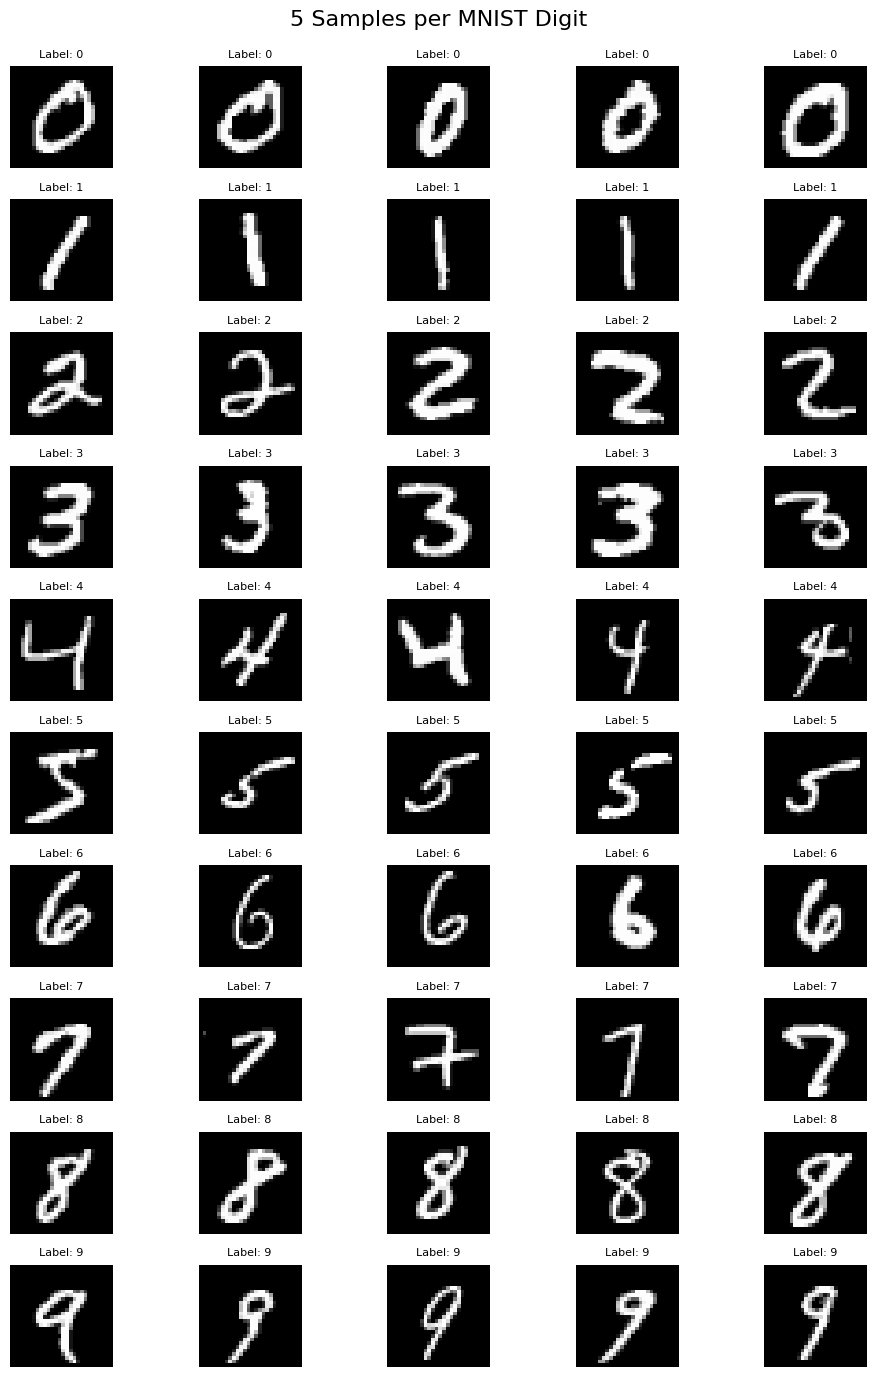

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(10, 14))

for digit in range(10):
    for i in range(5):
        img = samples_by_class[digit][i]
        ax = axes[digit][i]

        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {digit}", fontsize=8)

plt.suptitle("5 Samples per MNIST Digit", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

# Part 2: Create MNIST101 dataset without augmentations

In [ ]:
digit_bank = defaultdict(list)
for img, label in mnist_data:
    digit_bank[label].append(img)

# Step 3: Define 3-digit class space
target_classes = [f"{i:03}" for i in range(101)]  # ['000', '001', ..., '100']
new_dataset = []

for cls in target_classes:
    count = 0
    while count < 4000:
        digits = [int(c) for c in cls]  # e.g., '023' → [0, 2, 3]
        imgs = [random.choice(digit_bank[d]) for d in digits]

        # Concatenate horizontally
        new_img = Image.new('L', (28*3, 28))
        for idx, img in enumerate(imgs):
            if isinstance(img, torch.Tensor):
                img = transforms.ToPILImage()(img)
            new_img.paste(img, (28*idx, 0))

        new_dataset.append((new_img, int(cls)))
        count += 1

print(f"Generated {len(new_dataset)} samples for {len(target_classes)} classes.")

Generated 404000 samples for 101 classes.


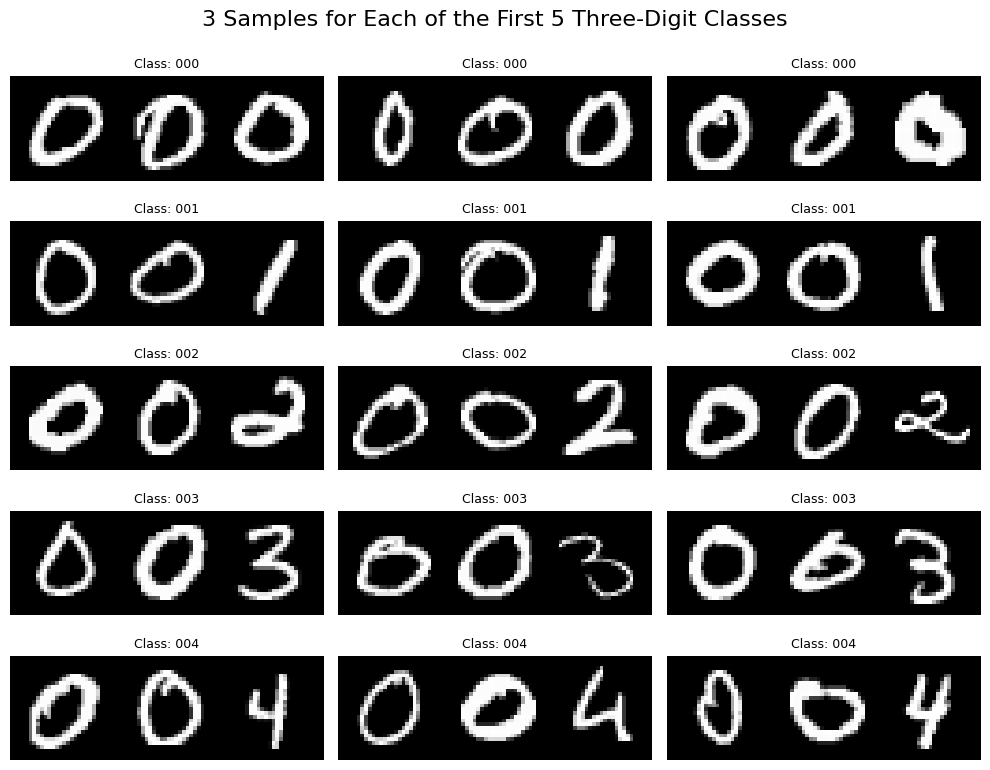

In [ ]:
samples_by_class = {i: [] for i in range(5)}  # 000–004

for img, label in new_dataset:
    if label in samples_by_class and len(samples_by_class[label]) < 3:
        samples_by_class[label].append(img)
    if all(len(samples_by_class[i]) == 3 for i in range(5)):
        break

# Plot them in a 5x3 grid (5 rows = classes, 3 cols = samples)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 8))
fig.suptitle("3 Samples for Each of the First 5 Three-Digit Classes", fontsize=16)

for class_idx in range(5):
    for sample_idx in range(3):
        ax = axes[class_idx, sample_idx]
        img = samples_by_class[class_idx][sample_idx]

        # Convert tensor to NumPy if needed
        if isinstance(img, torch.Tensor):
            img = img.squeeze().numpy()

        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {class_idx:03}", fontsize=9)
        ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Part 3: Define augmentations and apply them to dataset

In [ ]:
def apply_flip(image, horizontal=True):
    """Apply horizontal or vertical flip to image"""
    if horizontal:
        return cv2.flip(image, 1)  # 1 for horizontal flip
    else:
        return cv2.flip(image, 0)  # 0 for vertical flip

In [ ]:
def apply_rotate(image, angle):
    """Rotate image by specified angle"""
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, rotation_matrix, (width, height))

In [ ]:
def apply_gaussian_noise(image, mean=0, sigma=25):
    """Add Gaussian noise to image"""
    row, col = image.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

In [ ]:
def apply_gaussian_blur(image, kernel_size=5):
    """Apply Gaussian blur to image"""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [ ]:
def apply_median_blur(image, kernel_size=5):
    """Apply median blur to image"""
    return cv2.medianBlur(image, kernel_size)

In [ ]:
def apply_zoom(image, scale_factor):
    """Zoom in/out of image by scale factor"""
    height, width = image.shape[:2]
    # Calculate new dimensions
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)

    # Resize the image
    resized = cv2.resize(image, (new_width, new_height))

    # If we're zooming in, crop the center
    if scale_factor > 1:
        start_x = (new_width - width) // 2
        start_y = (new_height - height) // 2
        resized = resized[start_y:start_y+height, start_x:start_x+width]
    # If we're zooming out, pad with zeros
    else:
        pad_y = (height - new_height) // 2
        pad_x = (width - new_width) // 2
        result = np.zeros((height, width), dtype=image.dtype)
        result[pad_y:pad_y+new_height, pad_x:pad_x+new_width] = resized
        resized = result

    return resized

In [ ]:
def apply_brightness(image, factor):
    """Adjust brightness of image"""
    hsv = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = np.clip(hsv[:,:,2] * factor, 0, 255)
    return cv2.cvtColor(cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)

In [ ]:
def apply_contrast(image, factor):
    """Adjust contrast of image"""
    mean = np.mean(image)
    return np.clip((image - mean) * factor + mean, 0, 255).astype(np.uint8)

In [ ]:
def apply_shear(image, shear_factor):
    """Apply shear transformation to image"""
    height, width = image.shape[:2]
    shear_matrix = np.array([[1, shear_factor, 0], [0, 1, 0]])
    return cv2.warpAffine(image, shear_matrix, (width, height))

In [ ]:
def apply_elastic_transform(image, alpha=40, sigma=5, random_state=None):
    """Apply elastic transformation to image"""
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = random_state.rand(*shape) * 2 - 1
    dy = random_state.rand(*shape) * 2 - 1

    dx = cv2.GaussianBlur(dx, (0, 0), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (0, 0), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    distorted_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distorted_image.reshape(shape)

In [ ]:
def apply_perspective_transform(image, strength=0.05):
    """Apply perspective transformation to image"""
    height, width = image.shape[:2]

    # Define source points
    src_points = np.float32([[0, 0], [width-1, 0], [0, height-1], [width-1, height-1]])

    # Define destination points with random offset
    dst_points = np.float32([
        [0 + random.uniform(-strength*width, strength*width), 0 + random.uniform(-strength*height, strength*height)],
        [width-1 + random.uniform(-strength*width, strength*width), 0 + random.uniform(-strength*height, strength*height)],
        [0 + random.uniform(-strength*width, strength*width), height-1 + random.uniform(-strength*height, strength*height)],
        [width-1 + random.uniform(-strength*width, strength*width), height-1 + random.uniform(-strength*height, strength*height)]
    ])

    # Calculate transformation matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    # Apply transformation
    return cv2.warpPerspective(image, M, (width, height))

In [ ]:
def apply_salt_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt and pepper noise to image"""
    noisy = np.copy(image)
    # Add salt
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy[salt_mask] = 255

    # Add pepper
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy[pepper_mask] = 0

    return noisy

In [ ]:
def apply_motion_blur(image, kernel_size=7):
    """Apply motion blur to image"""
    # Create kernel
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[kernel_size//2, :] = 1
    kernel = kernel / kernel_size

    # Apply kernel
    return cv2.filter2D(image, -1, kernel)

In [ ]:
def apply_emboss(image):
    """Apply emboss effect to image"""
    kernel = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
    return cv2.filter2D(image, -1, kernel)

In [ ]:
def apply_edge_enhance(image):
    """Enhance edges in image"""
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)

In [ ]:
def get_safe_augmentations():
    """Get augmentations that are safe for digit recognition"""
    return A.Compose([
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 3), p=0.5),
            A.MedianBlur(blur_limit=(3, 3), p=0.5),
        ], p=0.3),

        A.OneOf([
            A.GaussNoise(p=0.5),
            A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),
        ], p=0.3),

        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            A.Equalize(p=0.5),
        ], p=0.3),

        A.OneOf([
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5),
        ], p=0.3),

        A.CoarseDropout(p=0.2),
    ])


In [ ]:
# Demonstrate augmentations on a sample image
def show_augmentation_examples(sample_image, num_examples=5):
    """Show examples of different augmentations on a sample image"""
    # Convert PIL image to numpy if needed
    if isinstance(sample_image, Image.Image):
        sample_np = np.array(sample_image)
    else:
        sample_np = sample_image

    # Ensure image is grayscale
    if len(sample_np.shape) == 3:
        sample_np = cv2.cvtColor(sample_np, cv2.COLOR_RGB2GRAY)

    # Create figure
    plt.figure(figsize=(15, 10))

    # Show original image
    plt.subplot(6, 3, 1)
    plt.imshow(sample_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Show Lab 3 augmentations
    augmentations = [
        ("Horizontal Flip", apply_flip(sample_np, horizontal=True)),
        ("Rotation (15°)", apply_rotate(sample_np, 15)),
        ("Gaussian Noise", apply_gaussian_noise(sample_np)),
        ("Gaussian Blur", apply_gaussian_blur(sample_np)),
        ("Median Blur", apply_median_blur(sample_np)),
        ("Zoom (1.2x)", apply_zoom(sample_np, 1.2))
    ]

    # Show new augmentations
    additional_augmentations = [
        ("Brightness", apply_brightness(sample_np, 1.3)),
        ("Contrast", apply_contrast(sample_np, 1.5)),
        ("Shear", apply_shear(sample_np, 0.2)),
        ("Salt & Pepper", apply_salt_pepper_noise(sample_np)),
        ("Motion Blur", apply_motion_blur(sample_np)),
        ("Emboss", apply_emboss(sample_np)),
        ("Edge Enhance", apply_edge_enhance(sample_np)),
        ("Random Crop", apply_random_crop_and_resize(sample_np)),
        # Removed perspective and elastic for simplicity
    ]

    # Plot all augmentations
    all_augmentations = augmentations + additional_augmentations

    for i, (title, img) in enumerate(all_augmentations):
        plt.subplot(6, 3, i+2)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Augmentation Examples for MNIST101", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

    # Demonstrate albumentation transforms
    aug_transforms = get_safe_augmentations()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(sample_np, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    for i in range(5):
        augmented = aug_transforms(image=sample_np)['image']
        plt.subplot(1, 6, i+2)
        plt.imshow(augmented, cmap='gray')
        plt.title(f"Albumentation {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Albumentation Transforms for MNIST101", fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

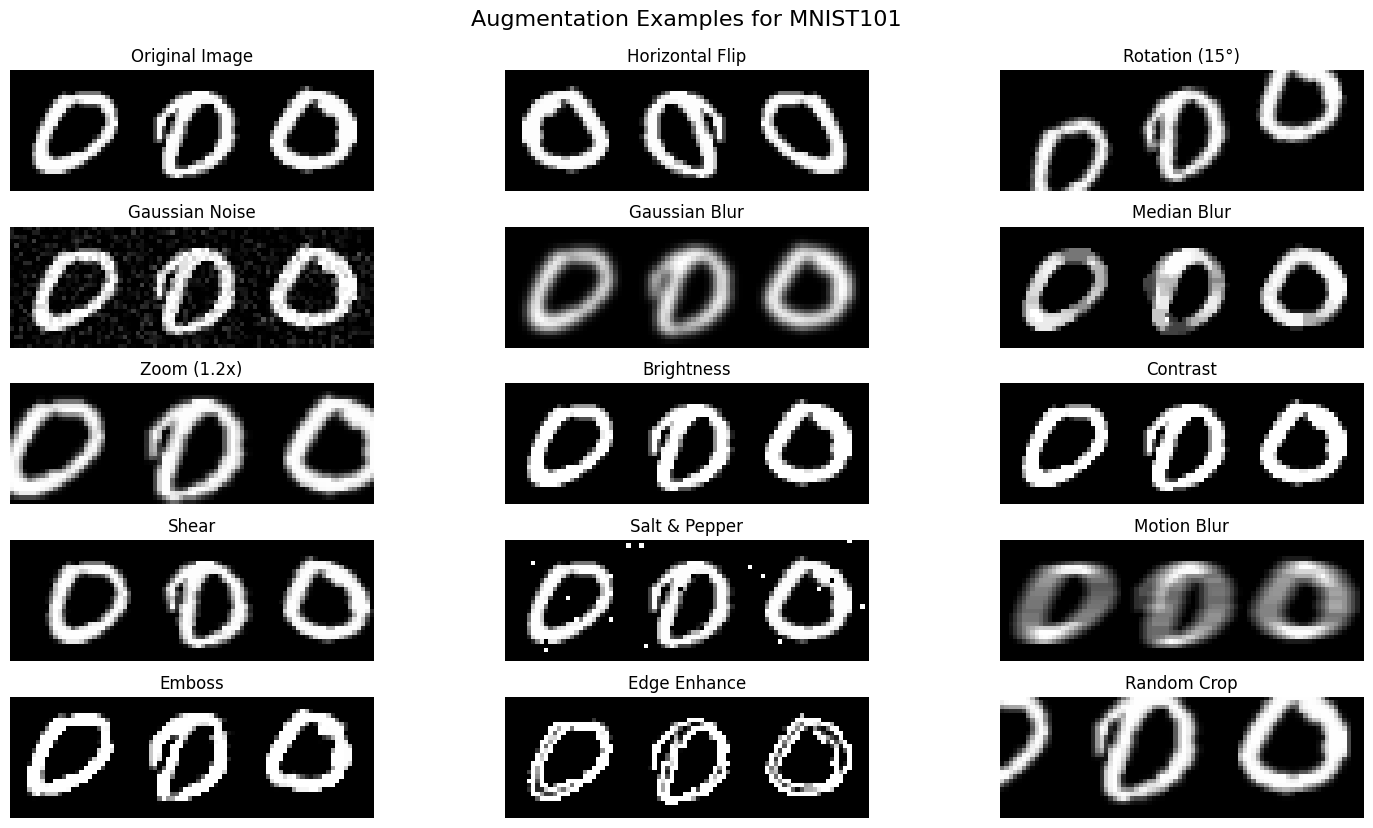

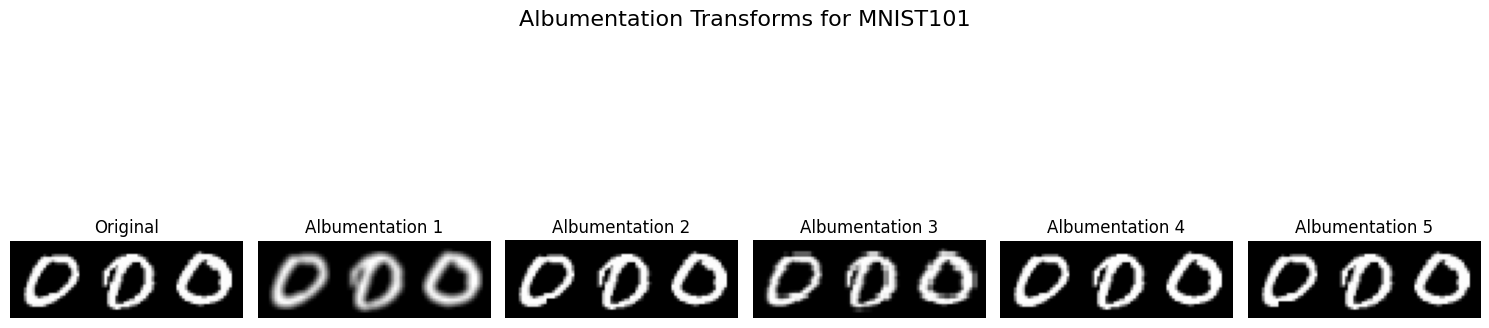

In [ ]:
# Display augmentation effects on a sample from MNIST101
sample_img = samples_by_class[0][0]  # First sample from class 000
show_augmentation_examples(sample_img)

# MNIST101 Augmentation Analysis

## Suitable Augmentations

✅ **Gaussian Blur, Median Blur**
- Simulates different scanning qualities
- Helps the model be robust to blurry inputs
- Should be kept moderate to preserve digit structure

✅ **Gaussian Noise, Salt & Pepper Noise**
- Simulates real-world noise in scanned or photographed digits
- Improves model robustness to noisy inputs

✅ **Brightness/Contrast Adjustments**
- Accounts for variations in lighting and scanning conditions
- Makes the model invariant to intensity changes

✅ **Mild Rotations (up to ±15°)**
- Simulates slight alignment differences
- Must be kept small to avoid changing digit meanings

✅ **Small Shifts, Shear, and Zoom**
- Accounts for positioning variations
- Simulates different handwriting styles

✅ **Random Crop and Resize**
- Trains the model to recognize digits from partial information

---

## Problematic Augmentations (Avoid or Use Carefully)

❌ **Large Rotations (>30°)**
- Can change digit meaning (e.g., 6 → 9, 2 → 5)
- Not realistic for natural digit orientations

❌ **Horizontal/Vertical Flips**
- Creates digits that don't exist in natural handwriting
- Changes the meaning of most digits (except possibly 0 and 8)

❌ **Extreme Distortions**
- Can make digits unrecognizable
- Not representative of real-world variations


# Part 4: Create MNIST101 Dataset class

In [ ]:
class MNIST101Dataset(Dataset):
    """
    PyTorch Dataset class for the MNIST101 dataset.
    Loads three-digit images and supports augmentations.
    """
    def __init__(self, data, transform=None, augment=False):
        """
        Initialize the MNIST101 dataset

        Args:
            data: List of (image, label) tuples
            transform: PyTorch transforms to apply
            augment: Whether to apply albumentation augmentations
        """
        self.data = data
        self.transform = transform  # PyTorch transforms
        self.augment = augment      # Whether to use albumentation augmentations

        # Define albumentation transforms if augmentation is enabled
        if self.augment:
            self.albu_transforms = get_safe_augmentations()

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset

        Args:
            idx: Index of the sample

        Returns:
            tuple: (image, label)
        """
        img, label = self.data[idx]

        # Convert PIL image to numpy array if needed
        if isinstance(img, Image.Image):
            img_np = np.array(img)
        else:
            img_np = img

        # Apply albumentation augmentations if requested
        if self.augment:
            augmented = self.albu_transforms(image=img_np)
            img_np = augmented['image']
            img = Image.fromarray(img_np)

        # Apply PyTorch transforms
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# Create train and test datasets
# Split dataset: 80% train, 20% test
train_size = int(0.8 * len(new_dataset))
test_size = len(new_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(new_dataset, [train_size, test_size])

In [ ]:
# Create MNIST101 datasets with PyTorch transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist101_train = MNIST101Dataset(train_dataset, transform=transform, augment=True)
mnist101_test = MNIST101Dataset(test_dataset, transform=transform, augment=False)

In [ ]:
# Create dataloaders
train_loader = DataLoader(mnist101_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist101_test, batch_size=32, shuffle=False)

Train DataLoader Samples:


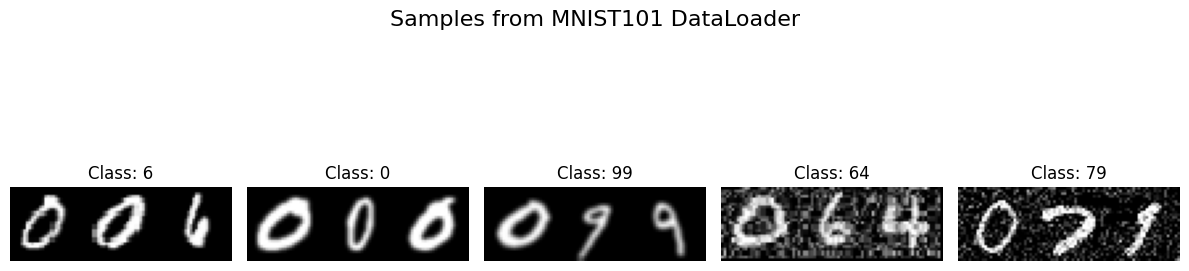

Test DataLoader Samples:


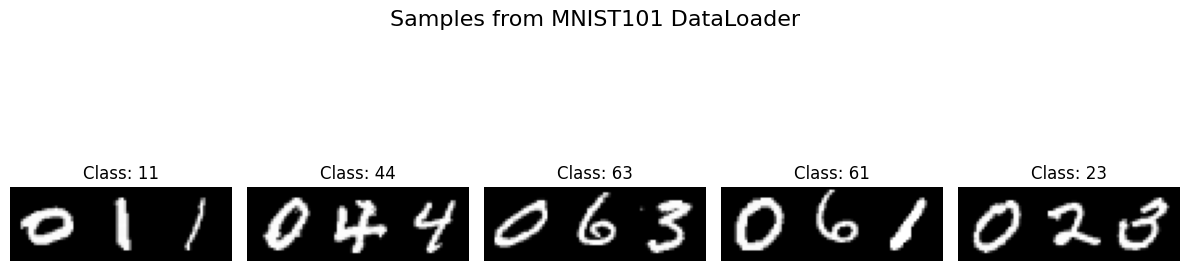

In [ ]:
# Display some samples from the dataloader
def show_batch_samples(dataloader, num_samples=5):
    """Show samples from a batch in dataloader"""
    # Get a batch
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Convert to numpy and show
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        # Convert tensor to numpy and denormalize
        img = images[i].squeeze().numpy()
        img = img * 0.3081 + 0.1307  # Reverse normalization
        plt.imshow(img, cmap='gray')
        plt.title(f"Class: {labels[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Samples from MNIST101 DataLoader", fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

# Show samples from train and test dataloaders
print("Train DataLoader Samples:")
show_batch_samples(train_loader)

print("Test DataLoader Samples:")
show_batch_samples(test_loader)

# Part 5: Project summary

# MNIST101 DATASET CREATION - PROJECT SUMMARY

---

## 1. Dataset Overview:
- Created **MNIST101** dataset with **101 classes** (000–100)
- Each class has **4000 samples**
- **Total dataset size:** 404000 images
- **Train set:** 323200 samples, **Test set:** 80800 samples

---

## 2. Implementation Steps:
- **a.** Downloaded and visualized original MNIST dataset
- **b.** Created three-digit images by concatenating MNIST digits
- **c.** Implemented 15 augmentation techniques:
  - **6 from Lab 3:**  
    *Flip, Rotate, Gaussian Noise, Gaussian Blur, Median Blur, Zoom*
  - **9 additional:**  
    *Brightness, Contrast, Shear, Salt & Pepper Noise, Motion Blur, Emboss, Edge Enhancement, Random Crop, and Albumentation transforms*
- **d.** Analyzed suitable augmentations for digit recognition
- **e.** Created PyTorch Dataset class for MNIST101
- **f.** Set up DataLoaders for training and testing

---

## 3. Design Considerations:
- **a. Augmentation selection:**
  - Avoided transforms that alter digit meaning (e.g., large rotations, flips)
  - Focused on realistic variations (noise, blur, small rotations)
- **b. Dataset organization:**
  - Used an 80/20 train/test split
  - Applied augmentations to the **training set only**
- **c. Implementation efficiency:**
  - Used Albumentations for fast, GPU-compatible transforms
  - Created proper PyTorch `Dataset` and MNIST101 interfaces

---

## 4. Future Work:
- Implement a CNN model to classify the three-digit numbers
- Experiment with different augmentation strategies
- Extend to more challenging variations (e.g., overlapping digits, different fonts)

---
